# AB テストの効果検証

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import seaborn as sns
import pymc as pm
import arviz as az
import random

random.seed(42)

In [3]:
# 確率モデル定義
model_suzuki = pm.Model()

with model_suzuki:
    # 事前分布
    p_page_a_suzuki = pm.Uniform('p_page_a_suzuki', lower=0.0, upper=1.0)
    p_page_b_suzuki = pm.Uniform('p_page_b_suzuki', lower=0.0, upper=1.0)
    # 二項分布で確率モデルを定義
    obs_page_a_suzuki = pm.Binomial('obs_page_a_suzuki', p=p_page_a_suzuki, observed=2, n=40)
    obs_page_b_suzuki = pm.Binomial('obs_page_b_suzuki', p=p_page_b_suzuki, observed=2, n=25)
    # 新たな確率変数として２つの確率変数の差を定義
    delta_prob_suzuki = pm.Deterministic('delta_prob_suzuki', p_page_b_suzuki - p_page_a_suzuki)

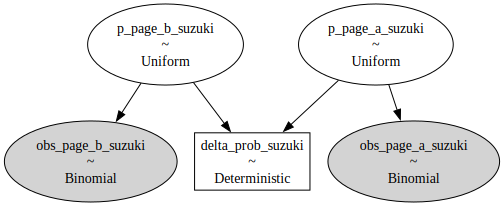

In [4]:
# 確率モデル可視化
pm.model_to_graphviz(model_suzuki)

In [5]:
# Sampling
with model_suzuki:
    inference_suzuki = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_page_a_suzuki, p_page_b_suzuki]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


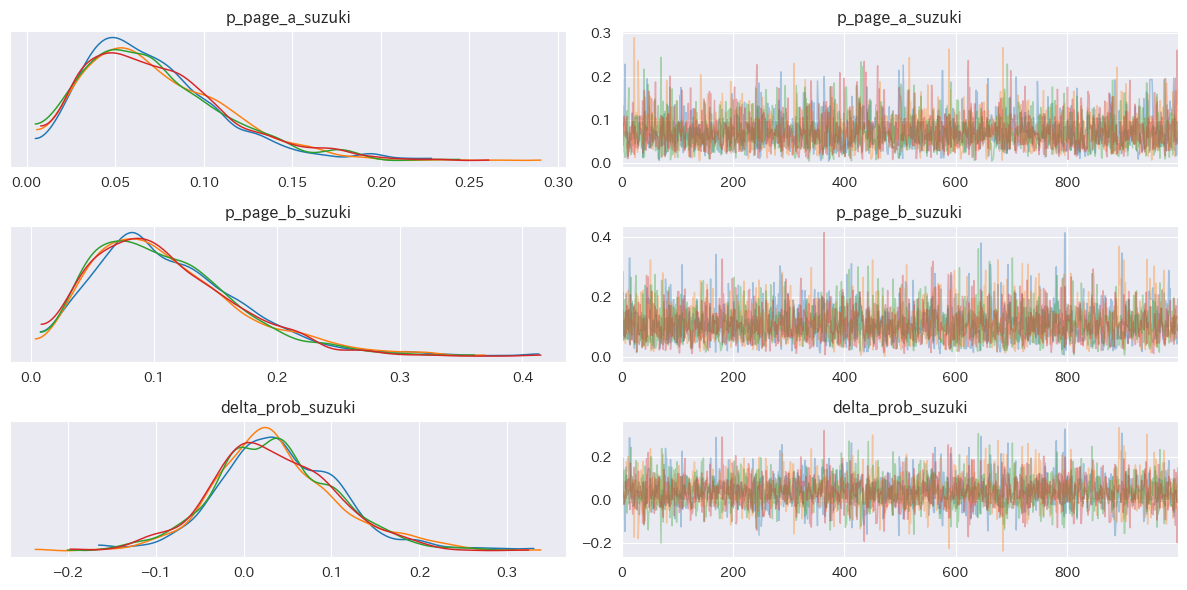

In [9]:
# 収束状況
az.plot_trace(inference_suzuki, compact=False)
plt.tight_layout()
plt.show()

- 左図: グラフがほぼ重なっている
- 右図: 均等にばらけている

問題なく収束できていると判断。

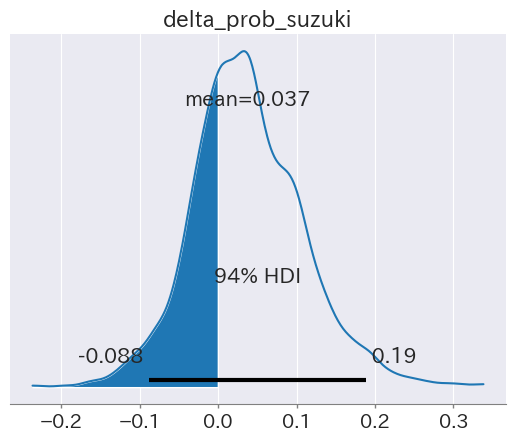

In [11]:
# 確率変数の分布
ax = az.plot_posterior(inference_suzuki, var_names=['delta_prob_suzuki'])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx < 0], yy[xx < 0])
plt.show()

負の値をとる領域がかなりある。

In [15]:
# 画面 A のほうがクリック率が高い確率
delta_prob_sample_suzuki = inference_suzuki['posterior'].data_vars['delta_prob_suzuki']  # Sampling結果から値を抽出
delta_prob_values_suzuki = delta_prob_sample_suzuki.values.reshape(-1)  # データを１列

n_minus_sample = (delta_prob_values_suzuki < 0).sum()  # delta_prob_suzuki がマイナスだった件数
n_sample       = len(delta_prob_values_suzuki)         # 全体のサンプル件数

n_rate_sample  = n_minus_sample / n_sample 

print(f"画面 A の方がクリック率が高い確率（鈴木）: {n_rate_sample * 100:.02f}%")

画面 A の方がクリック率が高い確率（鈴木）: 30.30%


- 「画面 B の方がクリック率が高い」という仮説は３回に１回はずれる
- 見た目の 3% クリック率増加は、サンプル数が少ないためたまたまそうなっている可能性がある

改善ページの効果があると判断するには相当のリスクがある